In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())

1 Physical GPUs, 1 Logical GPUs
True
True


# Immitation learning

## Data

### Imports

In [4]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
from PIL import Image

from io import BytesIO
import os

In [2]:
with ZipFile('recording_1.zip', 'r') as zf:
    zf.extractall()

In [5]:
img_df = []

images_folder = 'images'
# Due to memory problems, we can only read 5000 images at a time
images = os.listdir(images_folder)[:100]

for index, file in enumerate(images):
    img_df.append(np.array(Image.open(f'{images_folder}/{file}'), dtype=np.uint8))
    
    completion = 100*(index+1) / len(images)
    print(f'{completion:.2f}%', end='\r')
print()

img_df = np.array(img_df, dtype=np.uint8)

100.00%


In [6]:
columns = []

for i in range(img_df.shape[1] * img_df.shape[2]):
    columns.extend([f'r{i}', f'g{i}', f'b{i}'])
    
print(len(columns))

1440000


In [7]:
img_df = pd.DataFrame(img_df.reshape((img_df.shape[0], img_df.shape[1]*img_df.shape[2]*img_df.shape[3]))
                      , columns=columns)

In [8]:
img_df.shape

(100, 1440000)

In [9]:
tab_df = pd.read_csv('tabular.csv', sep=',')[:100]
tab_df = tab_df[['joy_x', 'joy_y']]
tab_df.shape

(100, 2)

### Showing data

In [1]:
import matplotlib.pyplot as plt

In [19]:
def show(image, title=None):
    plt.imshow(
        image,
        vmin=0, vmax=255 # , cmap='rgb'
    )
    if title is not None:
        plt.title(title)
        
    plt.show()

In [63]:
import cv2 as cv

ratio = 1 / 8

img = np.array(img_df[5:6]).reshape(600,800,3)

height = int(img.shape[0] * ratio)
width = int(img.shape[1] * ratio)

test = cv.resize(img, (width,height))

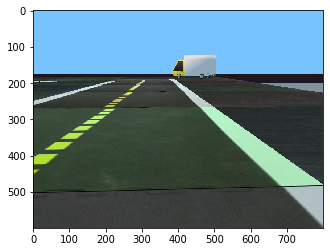

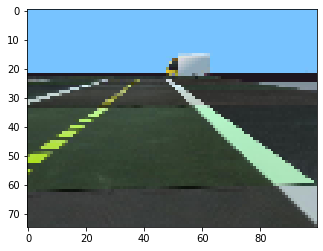

In [64]:
show(img)
show(test)

In [70]:
import cv2 as cv

images = []
ratio = 1 / 8

for image in img_df.values:
    image = image.reshape(600,800,3)
    
    height = int(image.shape[0] * ratio)
    width = int(image.shape[1] * ratio)
    
    images.append(cv.resize(image, (width,height)))
    
images = np.array(images)

In [71]:
images.shape

(100, 75, 100, 3)

### Only using usefull data

In [14]:
img_df.head()

,r0,g0,b0,r1,g1,b1,r2,g2,b2,r3,...,b479996,r479997,g479997,b479997,r479998,g479998,b479998,r479999,g479999,b479999
0,119,195,255,119,195,255,119,195,255,119,...,55,41,55,55,43,57,57,43,57,57
1,56,57,59,56,57,59,56,57,59,56,...,253,189,238,253,189,238,253,189,238,253
2,119,195,255,119,195,255,119,195,255,119,...,47,46,48,47,46,48,47,46,48,47
3,119,195,255,119,195,255,119,195,255,119,...,39,42,40,41,46,44,45,48,46,47
4,119,195,255,119,195,255,119,195,255,119,...,64,63,65,64,63,65,64,64,66,65


In [15]:
tab_df.head()

,joy_x,joy_y
0,-0.34,1.0
1,-0.29,1.0
2,-0.27,1.0
3,-0.25,1.0
4,-0.15,1.0


In [28]:
# combined_df = pd.concat([img_df, tab_df], axis=1)
# combined_df.shape

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, tab_df,
                                                    test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(img_df, tab_df,
#                                                    test_size=0.33, random_state=42)
img_df = None
tab_df = None

## Model

In [77]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D

model = Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(75,100,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2, activation='tanh'))

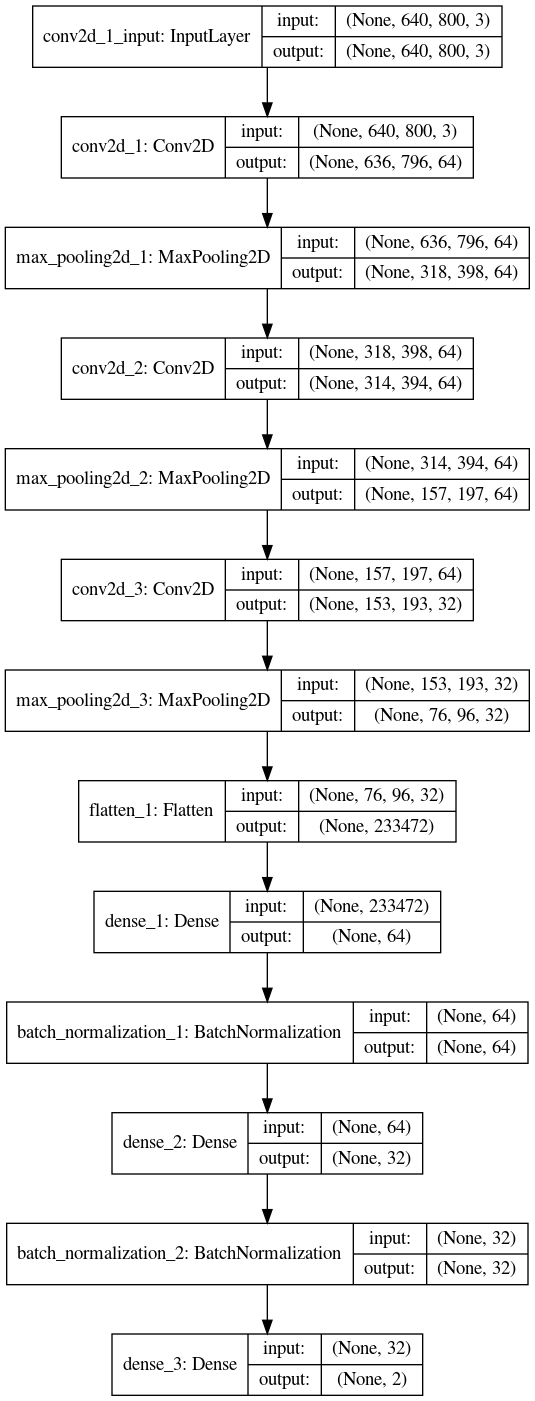

In [44]:
from keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

In [78]:
model.compile(loss='mean_absolute_error', optimizer='adam')

## Training

In [79]:
X_train_reshaped = np.array(X_train, dtype=np.uint8).reshape((X_train.shape[0], 75,100,3))
y_train_reformat = np.array(y_train * 100, dtype=np.uint8)

In [80]:
history = model.fit(X_train_reshaped, y_train_reformat, epochs=1, batch_size=1)

Epoch 1/1


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_4/convolution (defined at /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_3628]

Function call stack:
keras_scratch_graph
